In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image
import random
from tqdm.auto import tqdm
import imageio
import einops
import torch
from torchvision.transforms import Compose, ToTensor, Normalize, Lambda
from torchvision.datasets import FashionMNIST
import os
device = torch.device("cuda:0")

In [2]:
import importlib
from GAN_modules import * 
from DDGAN import *

In [3]:
transform = Compose([
    ToTensor(),
    Lambda(lambda x: (x - 0.5) * 2)]
)
batch_size = 64

dataset = FashionMNIST("./datasets", download=True, train=True, transform=transform)
loader = DataLoader(dataset, batch_size, shuffle=True)

In [94]:
def compute_gradient_penalty(netD, x_t_real,
                        x_tp1, t, x_t_fake):

    alpha = torch.tensor(np.random.random((x_t_real.size(0), 1, 1, 1)),
                         dtype=torch.float32, device=device)
    
    interpolates = (alpha * x_t_real + ((1 - alpha) * x_t_fake)).requires_grad_(True)
    d_interpolates = netD(interpolates, t, x_tp1)
    
    fake = torch.ones((x_t_real.shape[0], 1), dtype=torch.float32, device=device)
    # Get gradient w.r.t. interpolates
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty



def training_loop(ddgan, loader, n_epochs, optimizerG, optimizerD, device, c, r1,
                  schedulerG=None, schedulerD=None, store_path="ddgan_model.pt"):

    best_loss = float("inf")
    n_steps = ddgan.n_steps
    netG = ddgan.generator
    netD = ddgan.discriminator

    pos_coeff = Posterior_Coefficients(ddgan, device)

    for epoch in tqdm(range(n_epochs), desc=f"Training progress", colour="#00ff00"):
        print(f'Epoch {epoch+1}/{n_epochs}')
        
        epoch_errG = 0.0
        epoch_errD = 0.0
           
        for step, batch in enumerate(tqdm(loader, leave=False, desc=f"Epoch {epoch + 1}/{n_epochs}", colour="#005500")):
            for p in netD.parameters():
                p.requires_grad = True
                        
            netD.zero_grad()
                
            x0 = batch[0].to(device)
            n = len(x0)
            
            t = torch.randint(0, n_steps, (n,)).to(device)
            
            x_t, x_tp1 = q_sample_pairs(ddgan, x0, t)
            x_t.requires_grad = True
            
            #train D with real            
            D_real = netD(x_t, t, x_tp1.detach()).view(-1)
            errD_real = (-D_real).mean()
            
            #errD_real.backward(retain_graph=True)
            
                                           
            #train D with fake from G
            latent_z = torch.randn(n, netG.zsize).to(device)
            
            x_0_predict = netG(x_tp1, t, latent_z)
            x_pos_sample = sample_posterior(pos_coeff, x_0_predict, x_tp1, t)
            
            output = netD(x_pos_sample, t, x_tp1.detach()).view(-1)
    
            errD_fake = (output).mean()
            #errD_fake.backward()
            
            #errD = errD_real.detach() + errD_fake.detach()
            
            gradient_penalty = compute_gradient_penalty(netD, x_t,
                                        x_tp1.data, t, x_pos_sample.data)
            
            errD = errD_real + errD_fake + r1 * gradient_penalty
            errD.backward()
            
            optimizerD.step()            
            
            #train G without D
            for p in netD.parameters():
                p.requires_grad = False

            netG.zero_grad()
            
            t = torch.randint(0, n_steps, (n,)).to(device)
            
            x_t, x_tp1 = q_sample_pairs(ddgan, x0, t)
            
            latent_z = torch.randn(n, netG.zsize).to(device)
            
            x_0_predict = netG(x_tp1.detach(), t, latent_z)
            x_pos_sample = sample_posterior(pos_coeff, x_0_predict, x_tp1, t)
            
            output = netD(x_pos_sample, t, x_tp1.detach()).view(-1)     
            
            errG = (-output).mean()
            
            errG.backward()
            optimizerG.step()

            epoch_errG += errG.detach() * n / len(loader.dataset)
            epoch_errD += errD.detach() * n / len(loader.dataset)
        
        if schedulerD is not None:
            schedulerD.step()
        if schedulerG is not None:
            schedulerG.step()

        log_string = f"G loss: {epoch_errG:.6f}, D loss: {epoch_errD:.6f}"

        # Storing the model
        torch.save(ddgan.state_dict(), store_path)
        print(log_string)
        print('-' * 75)
    torch.cuda.empty_cache()

In [95]:
from CustomizableCosineDecayScheduler import CosineDecayWithWarmUpScheduler as CD_scheduler
n_steps, min_beta, max_beta = 10, 3e-1, 9e-1
c = 0.03
r1 = 1

In [121]:
# try:
#     del generator
# except: pass
# try:
#     del discriminator
# except: pass
# try:
#     del ddgan
# except: pass
# torch.cuda.empty_cache()


# generator = Generator(time_emb_dim=50, n_steps=n_steps, device=device, zsize=100)
# discriminator = Discriminator(time_emb_dim=50, n_steps=n_steps, device=device)


# ddgan = DDGAN(generator, discriminator, n_steps=n_steps, 
#               min_beta=min_beta, max_beta=max_beta, emb_dim=50,
#               device=device).to(device)
ddgan = best_model


# optimizerG = optim.Adam(ddgan.generator.parameters(), betas=(0.7, 0.95),
#                        lr=3e-4)
# optimizerD = optim.Adam(ddgan.discriminator.parameters(), betas=(0.7, 0.95),
#                        lr=1e-4)

# schedulerG = CD_scheduler(optimizerG, 
#                     max_lr=3e-4, min_lr=3e-6, num_step_down=20, 
#                     num_step_up=0, gamma=0.7, alpha=0.3)
# schedulerD = CD_scheduler(optimizerG, 
#                     max_lr=1e-4, min_lr=1e-6, num_step_down=20, 
#                     num_step_up=0, gamma=0.4, alpha=0.2)
optimizerG = optim.Adam(ddgan.generator.parameters(), betas=(0.7, 0.95),
                       lr=3e-5)
optimizerD = optim.Adam(ddgan.discriminator.parameters(), betas=(0.7, 0.95),
                       lr=1e-5)

schedulerG = CD_scheduler(optimizerG, 
                    max_lr=3e-5, min_lr=3e-7, num_step_down=20, 
                    num_step_up=0, gamma=0.6, alpha=0.3)
schedulerD = CD_scheduler(optimizerG, 
                    max_lr=1e-5, min_lr=1e-7, num_step_down=20, 
                    num_step_up=0, gamma=0.4, alpha=0.2)

ddgan.train()
training_loop(ddgan, loader, n_epochs=40, optimizerG=optimizerG, optimizerD=optimizerD, 
              c=c, r1=r1, schedulerG=schedulerG, schedulerD=schedulerD,
              device=device, store_path="ddgan_wd_model.pt")

Training progress:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1/40


Epoch 1/40:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: 4.237150, D loss: -0.129069
---------------------------------------------------------------------------
Epoch 2/40


Epoch 2/40:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: 3.279790, D loss: -0.099377
---------------------------------------------------------------------------
Epoch 3/40


Epoch 3/40:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: 2.890577, D loss: -0.085926
---------------------------------------------------------------------------
Epoch 4/40


Epoch 4/40:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: 4.339669, D loss: -0.081993
---------------------------------------------------------------------------
Epoch 5/40


Epoch 5/40:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: 3.984553, D loss: -0.080340
---------------------------------------------------------------------------
Epoch 6/40


Epoch 6/40:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: 4.266597, D loss: -0.061504
---------------------------------------------------------------------------
Epoch 7/40


Epoch 7/40:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: 3.738050, D loss: -0.057772
---------------------------------------------------------------------------
Epoch 8/40


Epoch 8/40:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: 2.760965, D loss: -0.053906
---------------------------------------------------------------------------
Epoch 9/40


Epoch 9/40:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: 2.389441, D loss: -0.059184
---------------------------------------------------------------------------
Epoch 10/40


Epoch 10/40:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: 1.263195, D loss: -0.061770
---------------------------------------------------------------------------
Epoch 11/40


Epoch 11/40:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: 0.695862, D loss: -0.067650
---------------------------------------------------------------------------
Epoch 12/40


Epoch 12/40:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: 0.633072, D loss: -0.076228
---------------------------------------------------------------------------
Epoch 13/40


Epoch 13/40:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: 0.923698, D loss: -0.081550
---------------------------------------------------------------------------
Epoch 14/40


Epoch 14/40:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: -0.596901, D loss: -0.091005
---------------------------------------------------------------------------
Epoch 15/40


Epoch 15/40:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: -0.916781, D loss: -0.104902
---------------------------------------------------------------------------
Epoch 16/40


Epoch 16/40:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: -1.030484, D loss: -0.112621
---------------------------------------------------------------------------
Epoch 17/40


Epoch 17/40:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: -1.078754, D loss: -0.127628
---------------------------------------------------------------------------
Epoch 18/40


Epoch 18/40:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: -2.270203, D loss: -0.140205
---------------------------------------------------------------------------
Epoch 19/40


Epoch 19/40:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: -2.164038, D loss: -0.155386
---------------------------------------------------------------------------
Epoch 20/40


Epoch 20/40:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: -2.184685, D loss: -0.172701
---------------------------------------------------------------------------
Epoch 21/40


Epoch 21/40:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: -1.318974, D loss: -0.200251
---------------------------------------------------------------------------
Epoch 22/40


Epoch 22/40:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: -1.812946, D loss: -0.166342
---------------------------------------------------------------------------
Epoch 23/40


Epoch 23/40:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: -2.614452, D loss: -0.129496
---------------------------------------------------------------------------
Epoch 24/40


Epoch 24/40:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: -2.508874, D loss: -0.125689
---------------------------------------------------------------------------
Epoch 25/40


Epoch 25/40:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: -2.172794, D loss: -0.107953
---------------------------------------------------------------------------
Epoch 26/40


Epoch 26/40:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: -1.743121, D loss: -0.102678
---------------------------------------------------------------------------
Epoch 27/40


Epoch 27/40:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: -1.634413, D loss: -0.108868
---------------------------------------------------------------------------
Epoch 28/40


Epoch 28/40:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: -2.600917, D loss: -0.097425
---------------------------------------------------------------------------
Epoch 29/40


Epoch 29/40:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: -2.316615, D loss: -0.097688
---------------------------------------------------------------------------
Epoch 30/40


Epoch 30/40:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: -2.058672, D loss: -0.098184
---------------------------------------------------------------------------
Epoch 31/40


Epoch 31/40:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: -0.982611, D loss: -0.107584
---------------------------------------------------------------------------
Epoch 32/40


Epoch 32/40:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: -2.405037, D loss: -0.112217
---------------------------------------------------------------------------
Epoch 33/40


Epoch 33/40:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: -2.621093, D loss: -0.112405
---------------------------------------------------------------------------
Epoch 34/40


Epoch 34/40:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: -1.346504, D loss: -0.119581
---------------------------------------------------------------------------
Epoch 35/40


Epoch 35/40:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: -1.750151, D loss: -0.122323
---------------------------------------------------------------------------
Epoch 36/40


Epoch 36/40:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: -1.508233, D loss: -0.136201
---------------------------------------------------------------------------
Epoch 37/40


Epoch 37/40:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: -2.549022, D loss: -0.144333
---------------------------------------------------------------------------
Epoch 38/40


Epoch 38/40:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: -2.166995, D loss: -0.146987
---------------------------------------------------------------------------
Epoch 39/40


Epoch 39/40:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: -2.530497, D loss: -0.157025
---------------------------------------------------------------------------
Epoch 40/40


Epoch 40/40:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: -4.100484, D loss: -0.175968
---------------------------------------------------------------------------


In [122]:
store_path="ddgan_wd_model.pt"

generator = Generator(time_emb_dim=50, n_steps=n_steps, device=device)
discriminator = Discriminator(time_emb_dim=50, n_steps=n_steps, device=device)

best_model = DDGAN(generator, discriminator, n_steps=n_steps, 
                   device=device, emb_dim=50)
best_model.load_state_dict(torch.load(store_path, map_location=device))
best_model.eval()
print()

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

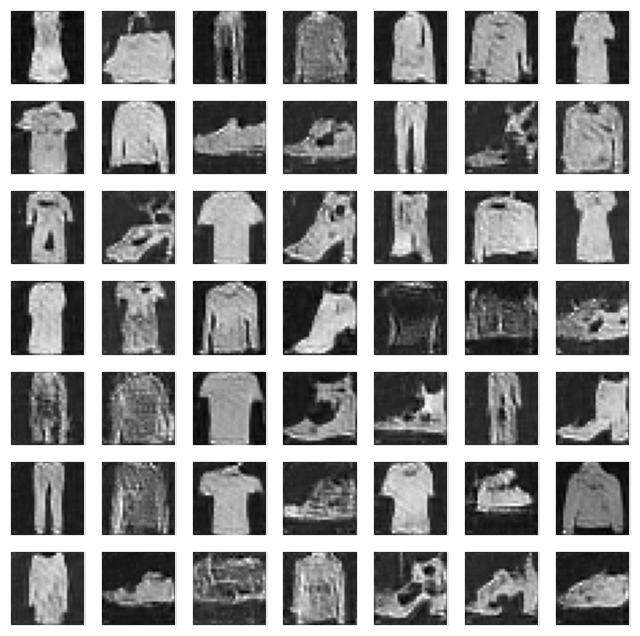

In [125]:
best_model.eval()
generated = generate_new_images(
        best_model,
        n_samples=49,
        n_steps=10
    )
show_images(generated, save_path=None)

In [126]:
# fake samples
n_samples=50000

os.makedirs(f"generated_ddgan_wd_FMNIST", exist_ok=True)

num_steps = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

for n in tqdm(num_steps, desc=f"Generating progress", colour="#00dd00"):
    
    torch.cuda.empty_cache()
    
    with torch.no_grad():

        generated = generate_new_images(
            best_model,
            n_samples=n_samples,
            n_steps=n
        )

    os.makedirs(f"generated_ddgan_wd_FMNIST/{n}", exist_ok=True)
    
    for i in range(len(generated)):
        save_image(torch.cat([generated[i],generated[i],generated[i]]), f"generated_ddgan_wd_FMNIST/{n}/img{i}.png")

Generating progress:   0%|          | 0/10 [00:00<?, ?it/s]

batches:   0%|          | 0/17 [00:00<?, ?it/s]

Steps:   0%|          | 0/1 [00:00<?, ?it/s]

Steps:   0%|          | 0/1 [00:00<?, ?it/s]

Steps:   0%|          | 0/1 [00:00<?, ?it/s]

Steps:   0%|          | 0/1 [00:00<?, ?it/s]

Steps:   0%|          | 0/1 [00:00<?, ?it/s]

Steps:   0%|          | 0/1 [00:00<?, ?it/s]

Steps:   0%|          | 0/1 [00:00<?, ?it/s]

Steps:   0%|          | 0/1 [00:00<?, ?it/s]

Steps:   0%|          | 0/1 [00:00<?, ?it/s]

Steps:   0%|          | 0/1 [00:00<?, ?it/s]

Steps:   0%|          | 0/1 [00:00<?, ?it/s]

Steps:   0%|          | 0/1 [00:00<?, ?it/s]

Steps:   0%|          | 0/1 [00:00<?, ?it/s]

Steps:   0%|          | 0/1 [00:00<?, ?it/s]

Steps:   0%|          | 0/1 [00:00<?, ?it/s]

Steps:   0%|          | 0/1 [00:00<?, ?it/s]

Steps:   0%|          | 0/1 [00:00<?, ?it/s]

batches:   0%|          | 0/17 [00:00<?, ?it/s]

Steps:   0%|          | 0/2 [00:00<?, ?it/s]

Steps:   0%|          | 0/2 [00:00<?, ?it/s]

Steps:   0%|          | 0/2 [00:00<?, ?it/s]

Steps:   0%|          | 0/2 [00:00<?, ?it/s]

Steps:   0%|          | 0/2 [00:00<?, ?it/s]

Steps:   0%|          | 0/2 [00:00<?, ?it/s]

Steps:   0%|          | 0/2 [00:00<?, ?it/s]

Steps:   0%|          | 0/2 [00:00<?, ?it/s]

Steps:   0%|          | 0/2 [00:00<?, ?it/s]

Steps:   0%|          | 0/2 [00:00<?, ?it/s]

Steps:   0%|          | 0/2 [00:00<?, ?it/s]

Steps:   0%|          | 0/2 [00:00<?, ?it/s]

Steps:   0%|          | 0/2 [00:00<?, ?it/s]

Steps:   0%|          | 0/2 [00:00<?, ?it/s]

Steps:   0%|          | 0/2 [00:00<?, ?it/s]

Steps:   0%|          | 0/2 [00:00<?, ?it/s]

Steps:   0%|          | 0/2 [00:00<?, ?it/s]

batches:   0%|          | 0/17 [00:00<?, ?it/s]

Steps:   0%|          | 0/3 [00:00<?, ?it/s]

Steps:   0%|          | 0/3 [00:00<?, ?it/s]

Steps:   0%|          | 0/3 [00:00<?, ?it/s]

Steps:   0%|          | 0/3 [00:00<?, ?it/s]

Steps:   0%|          | 0/3 [00:00<?, ?it/s]

Steps:   0%|          | 0/3 [00:00<?, ?it/s]

Steps:   0%|          | 0/3 [00:00<?, ?it/s]

Steps:   0%|          | 0/3 [00:00<?, ?it/s]

Steps:   0%|          | 0/3 [00:00<?, ?it/s]

Steps:   0%|          | 0/3 [00:00<?, ?it/s]

Steps:   0%|          | 0/3 [00:00<?, ?it/s]

Steps:   0%|          | 0/3 [00:00<?, ?it/s]

Steps:   0%|          | 0/3 [00:00<?, ?it/s]

Steps:   0%|          | 0/3 [00:00<?, ?it/s]

Steps:   0%|          | 0/3 [00:00<?, ?it/s]

Steps:   0%|          | 0/3 [00:00<?, ?it/s]

Steps:   0%|          | 0/3 [00:00<?, ?it/s]

batches:   0%|          | 0/17 [00:00<?, ?it/s]

Steps:   0%|          | 0/4 [00:00<?, ?it/s]

Steps:   0%|          | 0/4 [00:00<?, ?it/s]

Steps:   0%|          | 0/4 [00:00<?, ?it/s]

Steps:   0%|          | 0/4 [00:00<?, ?it/s]

Steps:   0%|          | 0/4 [00:00<?, ?it/s]

Steps:   0%|          | 0/4 [00:00<?, ?it/s]

Steps:   0%|          | 0/4 [00:00<?, ?it/s]

Steps:   0%|          | 0/4 [00:00<?, ?it/s]

Steps:   0%|          | 0/4 [00:00<?, ?it/s]

Steps:   0%|          | 0/4 [00:00<?, ?it/s]

Steps:   0%|          | 0/4 [00:00<?, ?it/s]

Steps:   0%|          | 0/4 [00:00<?, ?it/s]

Steps:   0%|          | 0/4 [00:00<?, ?it/s]

Steps:   0%|          | 0/4 [00:00<?, ?it/s]

Steps:   0%|          | 0/4 [00:00<?, ?it/s]

Steps:   0%|          | 0/4 [00:00<?, ?it/s]

Steps:   0%|          | 0/4 [00:00<?, ?it/s]

batches:   0%|          | 0/17 [00:00<?, ?it/s]

Steps:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:   0%|          | 0/5 [00:00<?, ?it/s]

batches:   0%|          | 0/17 [00:00<?, ?it/s]

Steps:   0%|          | 0/6 [00:00<?, ?it/s]

Steps:   0%|          | 0/6 [00:00<?, ?it/s]

Steps:   0%|          | 0/6 [00:00<?, ?it/s]

Steps:   0%|          | 0/6 [00:00<?, ?it/s]

Steps:   0%|          | 0/6 [00:00<?, ?it/s]

Steps:   0%|          | 0/6 [00:00<?, ?it/s]

Steps:   0%|          | 0/6 [00:00<?, ?it/s]

Steps:   0%|          | 0/6 [00:00<?, ?it/s]

Steps:   0%|          | 0/6 [00:00<?, ?it/s]

Steps:   0%|          | 0/6 [00:00<?, ?it/s]

Steps:   0%|          | 0/6 [00:00<?, ?it/s]

Steps:   0%|          | 0/6 [00:00<?, ?it/s]

Steps:   0%|          | 0/6 [00:00<?, ?it/s]

Steps:   0%|          | 0/6 [00:00<?, ?it/s]

Steps:   0%|          | 0/6 [00:00<?, ?it/s]

Steps:   0%|          | 0/6 [00:00<?, ?it/s]

Steps:   0%|          | 0/6 [00:00<?, ?it/s]

batches:   0%|          | 0/17 [00:00<?, ?it/s]

Steps:   0%|          | 0/7 [00:00<?, ?it/s]

Steps:   0%|          | 0/7 [00:00<?, ?it/s]

Steps:   0%|          | 0/7 [00:00<?, ?it/s]

Steps:   0%|          | 0/7 [00:00<?, ?it/s]

Steps:   0%|          | 0/7 [00:00<?, ?it/s]

Steps:   0%|          | 0/7 [00:00<?, ?it/s]

Steps:   0%|          | 0/7 [00:00<?, ?it/s]

Steps:   0%|          | 0/7 [00:00<?, ?it/s]

Steps:   0%|          | 0/7 [00:00<?, ?it/s]

Steps:   0%|          | 0/7 [00:00<?, ?it/s]

Steps:   0%|          | 0/7 [00:00<?, ?it/s]

Steps:   0%|          | 0/7 [00:00<?, ?it/s]

Steps:   0%|          | 0/7 [00:00<?, ?it/s]

Steps:   0%|          | 0/7 [00:00<?, ?it/s]

Steps:   0%|          | 0/7 [00:00<?, ?it/s]

Steps:   0%|          | 0/7 [00:00<?, ?it/s]

Steps:   0%|          | 0/7 [00:00<?, ?it/s]

batches:   0%|          | 0/17 [00:00<?, ?it/s]

Steps:   0%|          | 0/8 [00:00<?, ?it/s]

Steps:   0%|          | 0/8 [00:00<?, ?it/s]

Steps:   0%|          | 0/8 [00:00<?, ?it/s]

Steps:   0%|          | 0/8 [00:00<?, ?it/s]

Steps:   0%|          | 0/8 [00:00<?, ?it/s]

Steps:   0%|          | 0/8 [00:00<?, ?it/s]

Steps:   0%|          | 0/8 [00:00<?, ?it/s]

Steps:   0%|          | 0/8 [00:00<?, ?it/s]

Steps:   0%|          | 0/8 [00:00<?, ?it/s]

Steps:   0%|          | 0/8 [00:00<?, ?it/s]

Steps:   0%|          | 0/8 [00:00<?, ?it/s]

Steps:   0%|          | 0/8 [00:00<?, ?it/s]

Steps:   0%|          | 0/8 [00:00<?, ?it/s]

Steps:   0%|          | 0/8 [00:00<?, ?it/s]

Steps:   0%|          | 0/8 [00:00<?, ?it/s]

Steps:   0%|          | 0/8 [00:00<?, ?it/s]

Steps:   0%|          | 0/8 [00:00<?, ?it/s]

batches:   0%|          | 0/17 [00:00<?, ?it/s]

Steps:   0%|          | 0/9 [00:00<?, ?it/s]

Steps:   0%|          | 0/9 [00:00<?, ?it/s]

Steps:   0%|          | 0/9 [00:00<?, ?it/s]

Steps:   0%|          | 0/9 [00:00<?, ?it/s]

Steps:   0%|          | 0/9 [00:00<?, ?it/s]

Steps:   0%|          | 0/9 [00:00<?, ?it/s]

Steps:   0%|          | 0/9 [00:00<?, ?it/s]

Steps:   0%|          | 0/9 [00:00<?, ?it/s]

Steps:   0%|          | 0/9 [00:00<?, ?it/s]

Steps:   0%|          | 0/9 [00:00<?, ?it/s]

Steps:   0%|          | 0/9 [00:00<?, ?it/s]

Steps:   0%|          | 0/9 [00:00<?, ?it/s]

Steps:   0%|          | 0/9 [00:00<?, ?it/s]

Steps:   0%|          | 0/9 [00:00<?, ?it/s]

Steps:   0%|          | 0/9 [00:00<?, ?it/s]

Steps:   0%|          | 0/9 [00:00<?, ?it/s]

Steps:   0%|          | 0/9 [00:00<?, ?it/s]

batches:   0%|          | 0/17 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

In [127]:
# extract features and calculate FID
from FID import extract_real_features, FID_score

# path_real = "datasets/FashionMNIST_png/"
# real_features = extract_real_features(path_real)

# with open('real_features.npy', "wb") as f:
#     np.save(f, real_features)
# torch.cuda.empty_cache()

with open("real_features.npy", 'rb') as f:
    real_features = np.load(f)

In [128]:
path_real = "real_features.npy"
num_steps = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

scores = []

for n in tqdm(num_steps, leave=False, desc=f"Progress", colour="#009900"):
    torch.cuda.empty_cache()
    path_fake = f"generated_ddgan_wd_FMNIST/{n}/"
    scores.append(FID_score(path_real, path_fake, True))

with open('FID_scores_FMNIST_ddgan_wd.npy', "wb") as f:
    np.save(f, np.array(scores))

Progress:   0%|          | 0/10 [00:00<?, ?it/s]

Feature extracting:   0%|          | 0/1000 [00:00<?, ?it/s]

Feature extracting:   0%|          | 0/1000 [00:00<?, ?it/s]

Feature extracting:   0%|          | 0/1000 [00:00<?, ?it/s]

Feature extracting:   0%|          | 0/1000 [00:00<?, ?it/s]

Feature extracting:   0%|          | 0/1000 [00:00<?, ?it/s]

Feature extracting:   0%|          | 0/1000 [00:00<?, ?it/s]

Feature extracting:   0%|          | 0/1000 [00:00<?, ?it/s]

Feature extracting:   0%|          | 0/1000 [00:00<?, ?it/s]

Feature extracting:   0%|          | 0/1000 [00:00<?, ?it/s]

Feature extracting:   0%|          | 0/1000 [00:00<?, ?it/s]

In [129]:
with open('FID_scores_FMNIST_ddgan_wd.npy', "rb") as f:
    scores = np.load(f)

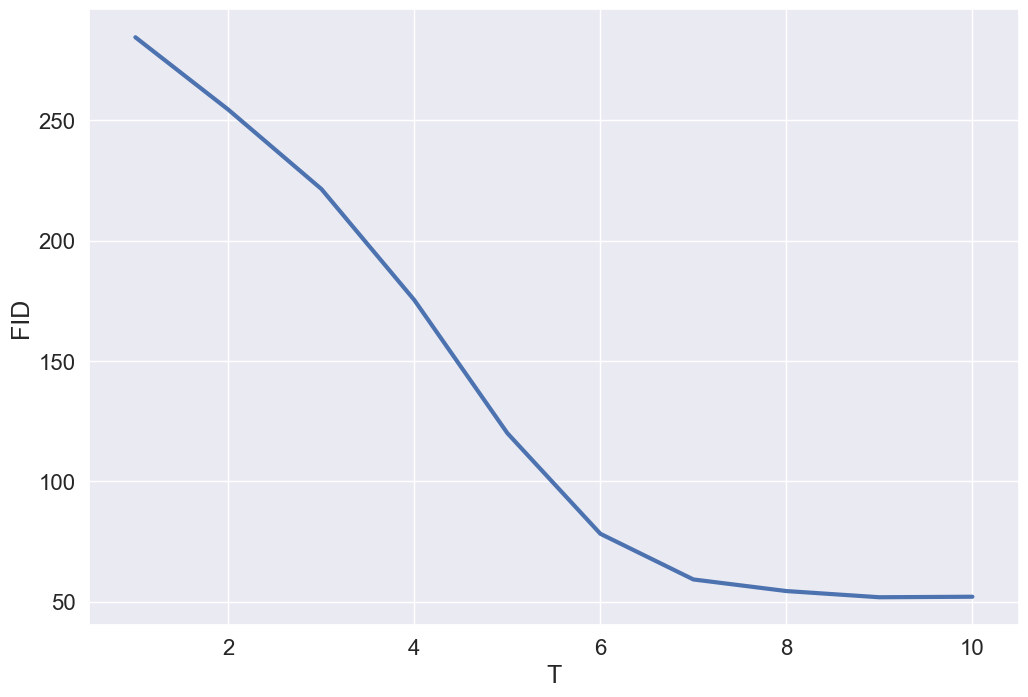

In [130]:
import seaborn as sns
sns.set_theme(style='darkgrid')

plt.figure(figsize=(12,8))

plt.plot(num_steps, scores, lw=3)

plt.xlabel("T", fontsize=18)
plt.ylabel("FID", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlim(left=0.5, right=10.5)

plt.savefig("DDGAN_WD_FID_FMNIST.png", bbox_inches='tight')
plt.show()